# <font color=Black>Twitter Sentiment Analysis

## <font color=Blue>Import Modules

In [1]:
# Machine Learning imports
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

import yfinance as yf

#from nltk.stem.wordnet import WordNetLemmatizerLoad

## <font color=Blue>Connecting Twitter

In [104]:
import tweepy

consumer_key = '2utzJ9JRRTfJdyzg0iyKteSDs'
consumer_secret = 'yRZVFqWxPcSFC1YGgBEtYNd2J3LvjmEBiinKik8f2nFsD3G6jX'
access_token = '1202794092444495873-IRM46wh2OJOH1T8hoCRmlsyC6RETrX'
access_token_secret = 'x5AaJCRwt5IOr2GomgoAdwAGE6w0Trl0WzplIwkPjxqfO'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## <font color=Blue>Download Conversations/Tweets

In [142]:
import csv
#####United Airlines
# Open/Create a file to append data
csvFile = open('ua.csv', 'a')
#Use csv Writer
csvWriter = csv.writer(csvFile)

end_date = '2019-12-15'
end_date_pd = pd.to_datetime(end_date)
start_date_pd = end_date_pd - BDay(90)
start_date = start_date_pd.strftime('%Y-%m-%d')


for tweet in tweepy.Cursor(api.search,q="#AAPL",count=100,
                           lang="en",
                           since="2019-09-01",
                           until="2019-12-06").items():
    print (tweet.created_at, tweet.text)
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])

In [127]:
colnames = ["Dates","Tweets"]
news_df=pd.read_csv('ua.csv',names = colnames,header  = None)
news_df.head(5)

,Dates,Tweets
0,2019-12-15 19:04:45,b'The Big Five #FAANG Stock and Sector Service...
1,2019-12-15 18:36:00,b'I could become a pro with this ipad Pro \xe2...
2,2019-12-15 16:09:32,b'RT @TrendSpider: $AAPL #AAPL Breakout... Loo...
3,2019-12-15 15:59:44,b'RT @TrendSpider: $AAPL #AAPL Breakout... Loo...
4,2019-12-15 15:55:33,b'$AAPL #AAPL Breakout... Looking forward to g...


## <font color=Blue>Removing special characters from Tweet

In [128]:
import re
news_df['Tweets'] = news_df['Tweets'].str[2:]
news_df['Tweets']=news_df.Tweets.apply(lambda x : re.sub('[^A-z0-9 -]', '', x).lower())

news_df.head()

,Dates,Tweets
0,2019-12-15 19:04:45,the big five faang stock and sector service is...
1,2019-12-15 18:36:00,i could become a pro with this ipad pro \xe2\x...
2,2019-12-15 16:09:32,rt trendspider aapl aapl breakout looking forw...
3,2019-12-15 15:59:44,rt trendspider aapl aapl breakout looking forw...
4,2019-12-15 15:55:33,aapl aapl breakout looking forward to going ov...


## <font color=Blue>Score each conversation

In [129]:
scores_list = []
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
for sentence in news_df['Tweets']:
    ss = sid.polarity_scores(sentence)
    scores_list.append(ss)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rupal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [130]:
scores_list

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.829, 'pos': 0.171, 'compound': 0.5719},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'compound': 0.3321},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'compound': 0.3321},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'compound': 0.4404},
 {'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'compound': 0.4404},
 {'neg': 0.099, 'neu': 0.807, 'pos': 0.094, 'compound': -0.0258},
 {'

In [131]:
neg_list = []
neu_list = []
pos_list = []
compound_list = []
for i in scores_list:
    neg_list.append(i['neg'])
    neu_list.append(i['neu'])
    pos_list.append(i['pos'])
    compound_list.append(i['compound'])

In [132]:
news_df['negative_score'] = neg_list
news_df['neutral_score'] = neu_list
news_df['positive_score'] = pos_list
news_df['compound_score'] = compound_list

news_df.head()

,Dates,Tweets,negative_score,neutral_score,positive_score,compound_score
0,2019-12-15 19:04:45,the big five faang stock and sector service is...,0.0,1.000,0.000,0.0000
1,2019-12-15 18:36:00,i could become a pro with this ipad pro \xe2\x...,0.0,0.829,0.171,0.5719
2,2019-12-15 16:09:32,rt trendspider aapl aapl breakout looking forw...,0.0,1.000,0.000,0.0000
3,2019-12-15 15:59:44,rt trendspider aapl aapl breakout looking forw...,0.0,1.000,0.000,0.0000
4,2019-12-15 15:55:33,aapl aapl breakout looking forward to going ov...,0.0,1.000,0.000,0.0000


## <font color=Blue>Assigning final Sentiment to each Conversation

In [133]:
def labeler (row):
    if row['compound_score'] <= -0.05 :
        return -1
    elif row['compound_score'] >= 0.05 :
        return 1
    else:
        return 0

In [134]:
news_df['Sentiment'] = news_df.apply (lambda row: labeler(row), axis=1)

news_df.head()

,Dates,Tweets,negative_score,neutral_score,positive_score,compound_score,Sentiment
0,2019-12-15 19:04:45,the big five faang stock and sector service is...,0.0,1.000,0.000,0.0000,0
1,2019-12-15 18:36:00,i could become a pro with this ipad pro \xe2\x...,0.0,0.829,0.171,0.5719,1
2,2019-12-15 16:09:32,rt trendspider aapl aapl breakout looking forw...,0.0,1.000,0.000,0.0000,0
3,2019-12-15 15:59:44,rt trendspider aapl aapl breakout looking forw...,0.0,1.000,0.000,0.0000,0
4,2019-12-15 15:55:33,aapl aapl breakout looking forward to going ov...,0.0,1.000,0.000,0.0000,0


## <font color=Blue>Defining Features

In [135]:
FeatureList=['sales ', 'dividends', 'stocks', 'equity', 'debt', 'financials']
news_df.Tweets = news_df.Tweets.apply(lambda x: x.split())
news_df['weights'] = 0

for i, row in news_df.iterrows():
      for t in row.Tweets:
            for k in FeatureList:
                if t == k:
                    temp = news_df.at[i,'weights'] 
                    news_df.at[i,'weights'] = temp + 1

In [136]:
news_df.weights.value_counts()

0    842
1     22
Name: weights, dtype: int64

## <font color=Blue>Creating 'Date' Feature

In [137]:
news_df.Dates = news_df.Dates.apply(lambda x: x[0:10])
news_df['Dates'] =  pd.to_datetime(news_df['Dates'])

datelist = []
today = pd.datetime.today()
from_date = today - BDay(6)
to_date = today - BDay(1)

## <font color=Blue>Downloading stock price data from Yahoo Finance

In [143]:
pd_df = yf.download('AAPL', start_date,end_date)
pd_df.drop(columns = ['Adj Close'], inplace = True)
pd_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2019-08-12,199.619995,202.050003,199.149994,200.479996,22474900
2019-08-13,201.020004,212.139999,200.479996,208.970001,47218500
2019-08-14,203.160004,206.440002,202.589996,202.750000,36547400
2019-08-15,203.460007,205.139999,199.669998,201.740005,27227400
2019-08-16,204.279999,207.160004,203.839996,206.500000,27620400


In [144]:
#Count of tweets for each day
news_df.Dates.value_counts()

2019-12-12    214
2019-12-10    134
2019-12-13    114
2019-12-09    100
2019-12-11     98
2019-12-14     62
2019-12-07     60
2019-12-08     54
2019-12-15     28
Name: Dates, dtype: int64

## <font color=Blue>Pie Chart showing Distribution of each Sentiment

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022A862A13C8>,
      dtype=object)

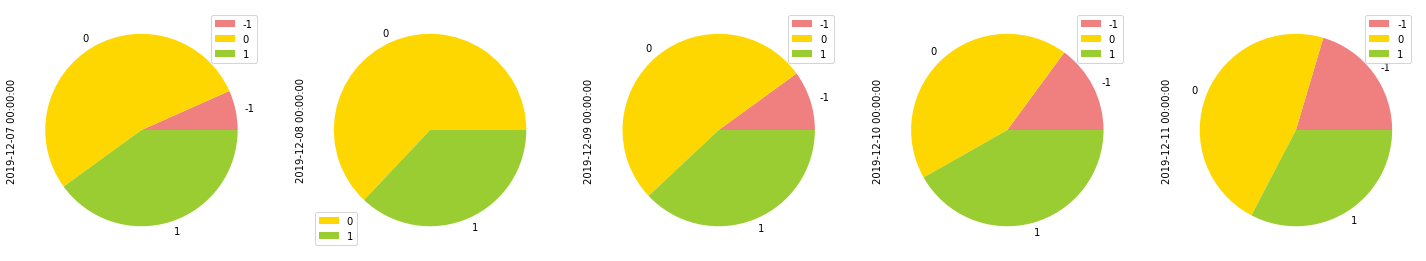

In [145]:
news_df['Dummy']=1

new_df=news_df.groupby(['Dates','Sentiment'])['Dummy'].count().unstack()
new_df[0:5].T.plot.pie(subplots=True, figsize=(25, 50), colors= ['lightcoral','gold', 'yellowgreen' ])

## <font color=Blue>Data Manipulation

In [146]:
news_df.drop(columns = ['Dummy'],inplace = True)
new_df.fillna(0)
new_df.reset_index(inplace=True)
new_df.rename(columns={'Dates': 'Date'},inplace = True)
df_merge_col = pd.merge(pd_df,new_df, on='Date')
df_merge_col.rename(columns = {-1:'AggNeg',1:'AggPos',0:'AggNeu'},inplace=True)
df_merge_col

,Date,Open,High,Low,Close,Volume,AggNeg,AggNeu,AggPos
0,2019-12-09,270.000000,270.799988,264.910004,266.920013,32010600,10.0,52.0,38.0
1,2019-12-10,268.600006,270.070007,265.859985,268.480011,22605100,20.0,58.0,56.0
2,2019-12-11,268.809998,271.100006,268.500000,270.769989,19689200,20.0,46.0,32.0
3,2019-12-12,267.779999,272.559998,267.320007,271.459991,34327600,26.0,146.0,42.0
4,2019-12-13,271.459991,275.299988,270.929993,275.149994,33432806,16.0,38.0,60.0


In [148]:
df_merge_col["Temp"] = (df_merge_col.AggNeg + df_merge_col.AggNeu + df_merge_col.AggPos)
df_merge_col.AggNeg = df_merge_col.AggNeg / df_merge_col.Temp
df_merge_col.AggNeu = df_merge_col.AggNeu / df_merge_col.Temp
df_merge_col.AggPos = df_merge_col.AggPos / df_merge_col.Temp
df_merge_col.drop(columns=['Temp'],inplace= True)

df_merge_col

,Date,Open,High,Low,Close,Volume,AggNeg,AggNeu,AggPos
0,2019-12-09,270.000000,270.799988,264.910004,266.920013,32010600,0.100000,0.520000,0.380000
1,2019-12-10,268.600006,270.070007,265.859985,268.480011,22605100,0.149254,0.432836,0.417910
2,2019-12-11,268.809998,271.100006,268.500000,270.769989,19689200,0.204082,0.469388,0.326531
3,2019-12-12,267.779999,272.559998,267.320007,271.459991,34327600,0.121495,0.682243,0.196262
4,2019-12-13,271.459991,275.299988,270.929993,275.149994,33432806,0.140351,0.333333,0.526316


## <font color=Blue>Correlation between Sentiment and Stock Parameters

In [149]:
corr_df = df_merge_col.corr(method ='pearson')
corr_df.loc['AggNeg':'AggPos', 'Open' : 'Volume']

,Open,High,Low,Close,Volume
AggNeg,-0.167683,-0.112016,0.427029,0.254542,-0.818966
AggNeu,-0.760052,-0.297504,-0.476073,-0.334758,0.279105
AggPos,0.858844,0.351085,0.366893,0.272689,-0.032284


## <font color=Blue>Plot of Sentiment vs Closing Price

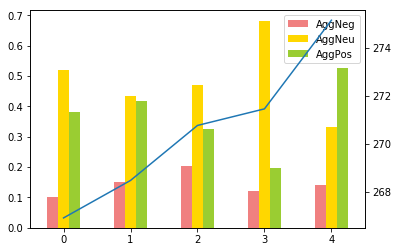

In [151]:
ax = df_merge_col[['AggNeg','AggNeu','AggPos']].plot(kind='bar',color= ['lightcoral','gold', 'yellowgreen'])
df_merge_col['Close'].plot(secondary_y=True, xlim=ax.get_xlim())

## <font color=Blue>Plot of Sentiment vs Volume of stock traded

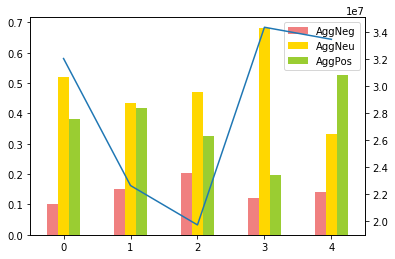

In [152]:
ax = df_merge_col[['AggNeg','AggNeu','AggPos']].plot(kind='bar',color= ['lightcoral','gold', 'yellowgreen'])
df_merge_col['Volume'].plot(secondary_y=True, xlim=ax.get_xlim())

## <font color=Blue>Plot of Sentiment vs Openinf Price

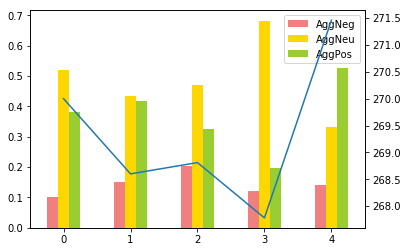

In [153]:
ax = df_merge_col[['AggNeg','AggNeu','AggPos']].plot(kind='bar',color= ['lightcoral','gold', 'yellowgreen'])
df_merge_col['Open'].plot(secondary_y=True, xlim=ax.get_xlim())

# <font color=Black>Conclusion
    
#### <font color=Red>Process
    
- This notebook is created for AAPL (Apple) stock, and it can be extended to any tradeable stock by changing the Ticker Symbol during data extractioon from Twitter and Yahoo Finance.

- Twitter API is used to get latest 1 week of tweets. Each tweet is then scored based on VADER SentimentIntensityAnalyzer which is part of Python toolkit. This Analyzer provides a compound score to each text string on the basis of in-built lexicon. The compound score can then be easily converted into Sentiment: Negative, Neutral and Positive

- Next step is to get data from Yahoo Finance for the same week as Twitter tweets. Both data is merged to do further analysis: Pie Chart, Correlation table, Trend chart

#### <font color=Red>Result
    
- For Apple stock, from the Correlation matrix, we see high negative correlation between "Negative sentiment" and "Volume traded", which can be viewed as trader's reservation to trade when market news is negative.
- Correlation between "Opening price" and "Positive Sentiment" is highly positive which tells if positive market sentiment leads to higher starting price.
    
    
#### <font color=Red>Limitation
- The correlation analysis can be further consolidated with more amount of data. However, Twitter limits the tweet extraction process for just a week.
    
    
    